# COVID-19 FAKE NEWS DETECTOR

This notebook consists of a deep learning model that predicts fake news or fake whatsapp forward messages. 

In [ ]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_f38670f214904a8c992e4cea40152cdf = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='jGyUTq7G_5QfXmNOUKh-PrXhJrRDcdGOAkMVieH8iW9L',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_f38670f214904a8c992e4cea40152cdf.get_object(Bucket='covid19fakenewsdetector-donotdelete-pr-hdqp5nr6km4cgp',Key='covidified.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='b57e8119-46dc-4170-8957-8dc84e804a66', project_access_token='p-a5fd6a28cf4bf3c15486e0031fe1b9af5e27a2d5')
pc = project.project_context

The dataset of fake news and genuine news is scraped from official news websites or governments sources and forums.
The scraped data is stored in form of csv file which imported using pandas dataframe.

In [3]:
import io
import pandas as pd
df2 = df_data_1

Following is the glimpse of dataset with labels.

In [4]:
print(df2)

     Head                                            Message     Type
0     NaN  Coronavirus update: MP tribal beaten to death ...  Genuine
1     NaN   A Pakistani doctor, Dr Osama Riazâ€™s last me...     Fake
2     NaN  Italian PM said that the country has surrender...     Fake
3     NaN  A video of bat infested roof claimed to be fro...     Fake
4     NaN   Netizens split over response to PMâ€™s diya call  Genuine
5     NaN  ‘Let’s light a lamp’: PM Modi tweets Atal Biha...  Genuine
6     NaN   Rotis hailing PM Modi shared in Madhya Prades...     Fake
7     NaN  In Italy people of all religions prostrate bef...     Fake
8     NaN   To defeat the coronavirus, China had built a ...     Fake
9     NaN  New Confirmed Case Of coronavirus In The Macar...     Fake
10    NaN           Turmeric and lemon can cure coronavirus.     Fake
11    NaN   Marathi newspaper reports conspiracy theory o...     Fake
12    NaN  Self-help groups have supplied 13 lakh masks:K...  Genuine
13    NaN  PM Modi r

In order to develop deep learning model we used the Tensorflow library.
The data is randomly splitted into testing and training dataset with a ratio of 1:4.
The labels are binarized to 0 and 1 where 0 being fake and 1 being grnuine.

In [5]:
import tensorflow as tf
import numpy as np
ds = pd.DataFrame(df2,columns=['Head','Message','Type'])
ds = ds.sample(frac=1)
label = []
for i in ds['Type']:
  if i=='Fake':
    label.append(0)
  else:
    label.append(1)
train_to_test = 0.75
length = len(ds)
x_train = ds['Message'][:int(length*train_to_test)]
y_train = label[:int(length*train_to_test)]
x_test = ds['Message'][int(length*train_to_test):]
y_test = label[int(length*train_to_test):]
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

2317 2317
773 773


Now the Natural Language Processing is implemented by tokenizing the text and encodeding the sentences using tensorflow functions.
After encoding the the array is padad with the maximum length of message which is 120.

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
vocab_size = 6000
embedding_dim = 100
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
# label_tokenizer = Tokenizer(num_words=3,oov_token=oov_tok)
# label_tokenizer.fit_on_texts(y_train)
# print(y_train)
# label_word_index = label_tokenizer.word_index
# print(label_word_index)
# label_sequence = np.array(label_tokenizer.texts_to_sequences(y_train))
# print(label_sequence[:500])
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
print(len(word_index))
vocab_size = len(word_index)
train_sequence = tokenizer.texts_to_sequences(x_train)
# print(train_sequence[0])
train_padded = pad_sequences(train_sequence,maxlen=max_length, padding=padding_type, truncating=trunc_type)
# print(train_padded[0])
test_sequence = tokenizer.texts_to_sequences(x_test)
print(test_sequence[23])
x_test = np.array(x_test)
print(x_test[23])
test_padded = pad_sequences(test_sequence,maxlen=max_length, padding=padding_type, truncating=trunc_type)
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
          if(logs.get('accuracy')>0.998):
              print("\nReached 99.8% accuracy so cancelling training!")
              self.model.stop_training = True
callback = myCallback()

5448
[1367, 105, 300, 1686, 43, 301, 3, 163, 136, 3437, 2173, 164]
DIY masks: What precautions you need to take while removing handmade mask


Now we create a neural network using the following layers and their length.

In [7]:
model = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid') ])
# adam = tf.keras.optimizers.Adam(0.002)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 100)          544900    
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 128)          84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 674,821
Trainable params: 674,821
Non-trainable params: 0
_________________________________________________________________


Now we convert the data to numpy array and then train with the above model for 5 epochs.

In [8]:
train_padded = np.array(train_padded)
y_train = np.array(y_train)
test_padded = np.array(test_padded)
y_test = np.array(y_test)
history = model.fit(train_padded,y_train, epochs=5, validation_data=(test_padded, y_test), verbose=1)

Train on 2317 samples, validate on 773 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
2317/2317 [==============================] - 315s 136ms/sample - loss: 0.4697 - acc: 0.7777 - val_loss: 0.2907 - val_acc: 0.8849
Epoch 2/5
2317/2317 [==============================] - 313s 135ms/sample - loss: 0.1170 - acc: 0.9625 - val_loss: 0.2242 - val_acc: 0.9276
Epoch 3/5
2317/2317 [==============================] - 324s 140ms/sample - loss: 0.0461 - acc: 0.9871 - val_loss: 0.2687 - val_acc: 0.9288
Epoch 4/5
2317/2317 [==============================] - 329s 142ms/sample - loss: 0.0366 - acc: 0.9914 - val_loss: 0.2554 - val_acc: 0.9224
Epoch 5/5
2317/2317 [==============================] - 306s 132ms/sample - loss: 0.0261 - acc: 0.9948 - val_loss: 0.2871 - val_acc: 0.9250


We achieved a maximum validation accuracy of 92.5% and training accuracy of 99.5%.
Following is the graphical representation of the accuracy and loss in the training.

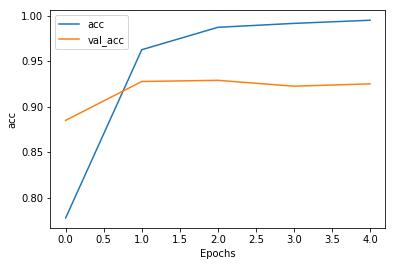

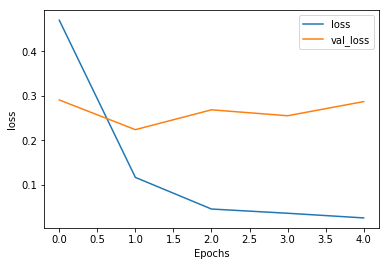

In [53]:
import matplotlib.pyplot as plt

def plot_graph(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graph(history, "acc")
plot_graph(history, "loss")

__Now we test the code for custom input.__

In [85]:
inp = input("Enter the news input:")
inp_seq = tokenizer.texts_to_sequences([inp])[0]
# print(inp)
print(inp_seq)
inp_pad = pad_sequences([inp_seq], maxlen=max_length, padding=padding_type, truncating=trunc_type )
# print(inp_pad)
predict = model.predict_classes(inp_pad,verbose=0)
if predict[0][0]==0:
  out = 'Fake'
else:
  out = 'Genuine'
print(out)

Enter the news input:People cannot prevent coronavirus infection through diet. However, a healthy life-style including balanced diet has a positive significance in maintaining an immune system against virus attack
[22, 723, 104, 7, 150, 167, 1, 258, 6, 1712, 544, 1, 262, 1, 1, 19, 6, 56, 1, 4, 2464, 37, 2091, 486, 76, 41, 705]
Genuine


__Now we try the model for other regional language Hindi__

We used IBMs translation api to convert the regional language text to English upon which we predict the output.

In [61]:
import sys
!{sys.executable} -m pip install ibm_watson

     |████████████████████████████████| 368kB 7.7MB/s eta 0:00:01
     |████████████████████████████████| 204kB 38.9MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/73/21/91/61a59270c329be2edc947c69871c25c50bf7dd87ebbfe07cdc
  Stored in directory: /home/dsxuser/.cache/pip/wheels/6a/42/50/f96888116b329578304f9dda4693cef6f3e76e18272d22cb6c
Successfully built ibm-watson ibm-cloud-sdk-core


In [91]:
from ibm_watson import LanguageTranslatorV3
from ibm_cloud_sdk_core.authenticators import BasicAuthenticator

authenticator = BasicAuthenticator('kavya.moolya@somaiya.edu','Ibm_1950')

language_translator = LanguageTranslatorV3(
    version='2018-08-01',
    authenticator=authenticator
)

language_translator.set_service_url('https://api.jp-tok.language-translator.watson.cloud.ibm.com/instances/e25b6b30-039e-4e7a-842d-df74eaa1ef83')
import json
from ibm_watson import LanguageTranslatorV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

authenticator = IAMAuthenticator('IS0J-al0JdS0n94z3VQZorB8DoRPstp-eTEKzGIlVIBt')
language_translator = LanguageTranslatorV3(
    version='2018-05-01',
    authenticator=authenticator
)

language_translator.set_service_url('https://api.jp-tok.language-translator.watson.cloud.ibm.com/instances/e25b6b30-039e-4e7a-842d-df74eaa1ef83')

translation = language_translator.translate(
    text= ' ईरान द्वारा विकसित कोरोना के लिए टीका',
    model_id='hi-en').get_result()
# print(json.dumps(translation, indent=2, ensure_ascii=False))
textin=translation['translations'][0]
text = (textin['translation'])

In [92]:
inp = text
print(inp)
print()
inp_seq = tokenizer.texts_to_sequences([inp])[0]
# print(inp)
print(inp_seq)
inp_pad = pad_sequences([inp_seq], maxlen=max_length, padding=padding_type, truncating=trunc_type )
# print(inp_pad)
predict = model.predict_classes(inp_pad,verbose=0)
if predict[0][0]==0:
  out = 'Fake'
else:
  out = 'Genuine'
print(out)

 Vaccine for Corona developed by Iran

[117, 12, 138, 379, 20, 806]
Fake
